In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_NO2 = pd.read_csv(r"C:\Users\Utente\PycharmProjects\DSS-project\mean_no2_monthlyvalues.csv")
df_NO2.head()

,Year_Month,Average NO2 Value
0,1990-01,37
1,1990-02,34
2,1990-03,38
3,1990-04,35
4,1990-05,38


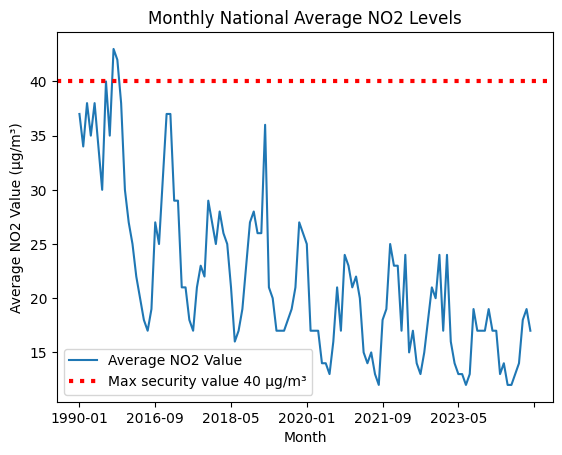

In [17]:
graph = df_NO2.plot('Year_Month', 'Average NO2 Value')
graph.set_title("Monthly National Average NO2 Levels")
graph.set_xlabel("Month")
graph.set_ylabel("Average NO2 Value (µg/m³)")
graph.axhline(y=40, color='red', linestyle=':', linewidth=3, label='Max security value 40 µg/m³')
graph.legend()


plt.show()

In [15]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


def draw_monthly_no2_average():
    df_NO2 = pd.read_csv(r"..\..\data\ProcessedData\mean_no2_monthlyvalues.csv")
    
    # Create the line plot
    fig = px.line(df_NO2, x='Year_Month', y='Average NO2 Value', 
                    title='Monthly National Average NO2 Levels')
    
    # Update layout
    fig.update_layout(
        xaxis_title="Month",
        yaxis_title="Average NO2 Value (µg/m³)",
        height=400,
        showlegend=True
    )
    
    # Add horizontal line for max security value
    fig.add_hline(y=40, line_dash="dot", line_color="red", line_width=3,
                    annotation_text="Max security value 40 µg/m³")

    return fig.to_html(include_plotlyjs='cdn', div_id='monthly_NO2_average').replace('<html>', '').replace('</html>', '').replace('<head><meta charset="utf-8" /></head>', '')

print(draw_monthly_no2_average())

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\data\\ProcessedData\\mean_no2_monthlyvalues.csv'

In [33]:
import folium
import pandas as pd
import geopandas as gpd
import ast
import os

def draw_LEZ_map():
    
    center_lat = 52.2
    center_lon = 5.3

    m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=7,
            tiles='CartoDB Positron'
        )

    # In Docker, data is mounted at /data, otherwise use relative path
    if os.path.exists("/data"):
        data_dir = "/data/processedData"
    else:
        # Fallback for local development (works in Jupyter where __file__ is not defined)
        try:
            script_dir = os.path.dirname(os.path.abspath(__file__))
        except NameError:
            # __file__ is not available in interactive environments like Jupyter;
            # use the current working directory instead.
            script_dir = os.getcwd()
        data_dir = os.path.join(script_dir, "..", "..", "data", "processedData")
        data_dir = os.path.normpath(data_dir)

    
    # Load NDW locations
    ndw_path = os.path.join(data_dir, "NDW_locations.csv")
    LEZ_location = pd.read_csv(ndw_path)
    LEZ_location.head()


    for idx, row in LEZ_location.iterrows():
        LEZ_location['coordinate_sets_list'] = LEZ_location['coordinate_sets'].apply(ast.literal_eval)
        LEZ_location['coordinate_sets_list'].iloc[idx][0] = LEZ_location['coordinate_sets_list'].iloc[idx][0].split()

        Lez_lat = LEZ_location['coordinate_sets_list'].iloc[idx][0][0]
        Lez_long = LEZ_location['coordinate_sets_list'].iloc[idx][0][1]

        folium.Marker(
        location=[Lez_lat, Lez_long],
        popup= LEZ_location['zone_name'].iloc[idx], # pop-up label for the marker
        icon=folium.Icon(color='red', icon='glyphicon-screenshot', icon_color='white')
        ).add_to(m)

    # Load province data
    geojson_path = os.path.join(data_dir, "georef-netherlands-provincie.geojson")
    json_path = os.path.join(data_dir, "georef-netherlands-provincie.json")
    
    gdf = gpd.read_file(geojson_path)
    df = pd.read_json(json_path)
    # Extract unique province names
    gdf['prov_name'] = df['prov_name']

    folium.GeoJson(gdf).add_to(m)
    

    return m._repr_html_()

    
print(draw_LEZ_map())

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\julia\\data\\processedData\\NDW_locations.csv'

In [40]:
# Import necessary packages
import os
import math
import folium
from folium import plugins
import earthpy as et
import earthpy.spatial as es
import pandas as pd
import geopandas as gpd
import numpy as np
from branca.element import Template, MacroElement

data = et.data.get_data('colorado-flood') # Importing geograhpcal data EarthPy

# Store the original working directory before earthpy changes it
original_cwd = os.getcwd()

os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data')) # working directory -> earth-analytics

AQI_NO2 = {
    (0, 10):           ("Good",           "green"),
    (10, 25):          ("Fair",           "yellow"),
    (25, 60):          ("Moderate",       "orange"),
    (60, 100):         ("Poor",           "red"),
    (100, 150):        ("Very Poor",      "darkred"),
    (150, math.inf):   ("Extremely Poor", "purple"),
}

def no2_colour_pollution(val): # colour based on no2 value range 
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return "gray"
    try:
        x = float(val)
    except (TypeError, ValueError):
        return "gray"
    for (lo, hi), (_label, color) in AQI_NO2.items():
        if lo <= x < hi:
            return color
    return "gray"


def norm_prov(p):                           # to allign province naam (Fryslân -> Friesland)
    if isinstance(p, list) and len(p) > 0:
        p = p[0]
    if isinstance(p, str):
        p = p.strip()
    return {"Fryslân": "Friesland"}.get(p, p)

# so no overlap in province name 
def load_geodata(geojson_path: str, json_path: str) -> pd.DataFrame: 
    # Use geopandas to read the GeoJSON file correctly
    gdf = gpd.read_file(geojson_path)
    df  = pd.read_json(json_path)  # Keep this as pd.read_json since it's a regular JSON file
   
    gdf['prov_name'] = df['prov_name']     
    gdf['province']  = gdf['prov_name'].apply(norm_prov)
    return gdf



def attach_no2_mean(gdf: pd.DataFrame, meanprovince: pd.DataFrame) -> pd.DataFrame: 
    mp = meanprovince.copy() # so province matches  meanprovince -
    mp["province"] = mp["RegioS"].apply(norm_prov)
    mean_map = dict(zip(mp["province"], mp["value"]))   # province -> NO2_mean 
    # add NO2_mean to gdf via with matching province name 
    gdf["NO2_mean"] = gdf["province"].map(mean_map)
    return gdf



def legenda(m, bins=AQI_NO2, title="Air Quality (NO₂)", unit="µg/m³"):
    items = sorted(((lo, hi, lbl, col) for (lo, hi), (lbl, col) in bins.items()), key=lambda t: t[0])
    rows = "".join(
        f'<div style="display:flex;align-items:center;margin:4px 0">'
        f'<span style="background:{col};width:12px;height:12px;border:1px solid #555;margin-right:8px"></span>'
        f'<span style="font-size:12px">{lbl} '
        f'<span style="color:#777">({int(lo)}–{("∞" if not math.isfinite(hi) else int(hi))} {unit})</span></span>'
        f'</div>' for lo, hi, lbl, col in items
    )
    html = ('<div style="position:fixed;bottom:20px;left:20px;z-index:9999;background:#fff;'
            'padding:8px 10px;border:1px solid #bbb;border-radius:4px;box-shadow:0 1px 4px rgba(0,0,0,.2)">'
            f'<div style="font-weight:600;margin-bottom:6px">{title}</div>{rows}</div>')
    macro = MacroElement(); macro._template = Template("{% macro html(this, kwargs) %}"+html+"{% endmacro %}")
    m.get_root().add_child(macro)

def build_map(gdf: pd.DataFrame, center_lat: float = 52.2, center_lon: float = 5.3) -> folium.Map:
    #map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=7, tiles="CartoDB Positron")
    for _, row in gdf.iterrows():
        prov = row["province"]
        geometry = row["geometry"]  # Use 'geometry' directly, not 'features.geometry'
        mean_no2 = row.get("NO2_mean")
        color = no2_colour_pollution(mean_no2)
        folium.GeoJson(
            geometry,
            style_function=lambda _x, c=color: {
                "fillColor": c,
                "color": "black",
                "weight": 2,
                "fillOpacity": 0.55,
            },
            name=prov,
            tooltip=folium.Tooltip(
                f"{prov}<br>NO₂ (mean): {mean_no2:.2f}" if pd.notna(mean_no2) else f"{prov}<br>NO₂: n.v.t."
            ),
        ).add_to(m)
    folium.LayerControl().add_to(m)
    return m

# Restore the original working directory to use relative paths correctly
os.chdir(original_cwd)


# Use relative paths from the current notebook location
# From main/Visualisation/ go up to main/ then into Preprocessors/
geojson_path = '../Preprocessors/georef-netherlands-provincie.geojson'
json_path    = '../Preprocessors/georef-netherlands-provincie.json'

print(f"Current working directory: {os.getcwd()}")
print(f"Looking for GeoJSON at: {os.path.abspath(geojson_path)}")
print(f"Looking for JSON at: {os.path.abspath(json_path)}")
print(f"GeoJSON exists: {os.path.exists(geojson_path)}")
print(f"JSON exists: {os.path.exists(json_path)}")

gdf = load_geodata(geojson_path, json_path)


province_data = gdf[['prov_name', 'geometry']].copy() # provinces and geometry (not 'features')
print(province_data)


m = build_map(gdf, center_lat=52.2, center_lon=5.3)  #folium map nl 
legenda(m)

m.save("no2_map.html")

Current working directory: C:\Users\julia\earth-analytics\data
Looking for GeoJSON at: C:\Users\julia\earth-analytics\Preprocessors\georef-netherlands-provincie.geojson
Looking for JSON at: C:\Users\julia\earth-analytics\Preprocessors\georef-netherlands-provincie.json
GeoJSON exists: False
JSON exists: False


DataSourceError: ../Preprocessors/georef-netherlands-provincie.geojson: No such file or directory